## Domača naloga 9/10
Marko Tacer, 23222087

Podatki:\
Cenilka : $H_2$\
Dolžina segmenta fft [$s$] : $0.75$\
Okno : Hann
Točka : $10$

In [1]:
import lvm_read
import matplotlib.pyplot as plt
from scipy import stats, integrate, signal
import numpy as np
import pickle
%matplotlib inline

#### Prikaz PSD

In [2]:
pot = 'mer_t10.pkl'
meritev = pickle.load(open(pot, 'rb'))
print(meritev.keys())

dict_keys(['data', 'fs', 'channels'])


In [3]:
fs = meritev['fs']
t = np.arange(0, 2, 1/fs)
dt = 1/fs

In [4]:
f = meritev['data'][:, 0, :]        # zložimo v časovno vrsto za silo
f_avg = np.mean(f, axis=0)          # dobimo povprečno časovno vrsto sila
x = meritev['data'][:, 1, :]        # zložimo v časovno vrsto za pospešek
x_avg = np.mean(x, axis=0)          # dobimo povprečno časovno vrsto pospešek
N = len(x[0])

F = np.fft.rfft(f, axis=-1) / N                 # izračunamo FFT časovne vrste sile
A = np.fft.rfft(x, axis=-1) / N                 # izračunamo FFT časovne vrste pospeška

freq = np.fft.rfftfreq(N, dt)           # izračunamo frekvence
F_avg = np.fft.rfft(f_avg) / N          # izračunamo FFT povprečne časovne vrste sile
A_avg = np.fft.rfft(x_avg) / N          # izračunamo FFT povprečne časovne vrste pospeška

PSD_F_avg = 2*F_avg.conj()*F_avg * 1/(N/fs)     # izračunamo PSD povprečne sile
PSD_A_avg = 2*A_avg.conj()*A_avg * 1/(N/fs)     # izračunamo PSD povprečnega pospeška

PSD_F = 2*F.conj()*F * (N/fs)**(-1)     # izračunamo PSD sile
PSD_A = 2*A.conj()*A * (N/fs)**(-1)     # izračunamo PSD pospeška

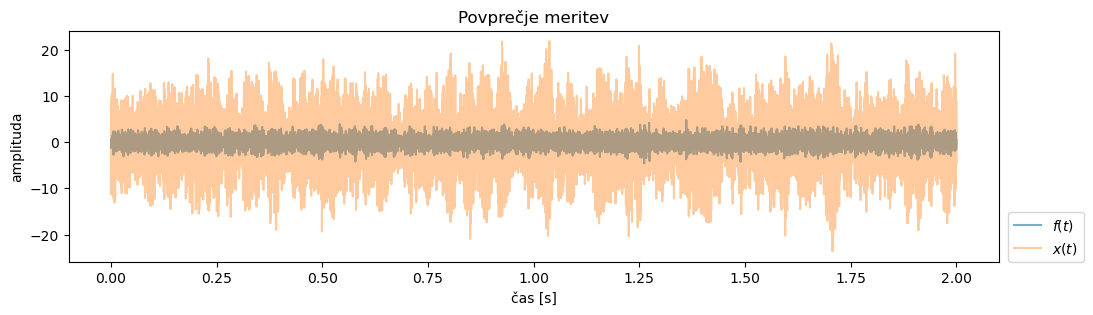

In [5]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Povprečje meritev')
ax.plot(t, f_avg, alpha=0.6, label=r'$f(t)$')
ax.plot(t, x_avg, alpha=0.4, label=r'$x(t)$')
ax.set_xlabel('čas [s]')
ax.set_ylabel('amplituda')
ax.legend(loc=(1.01, 0));

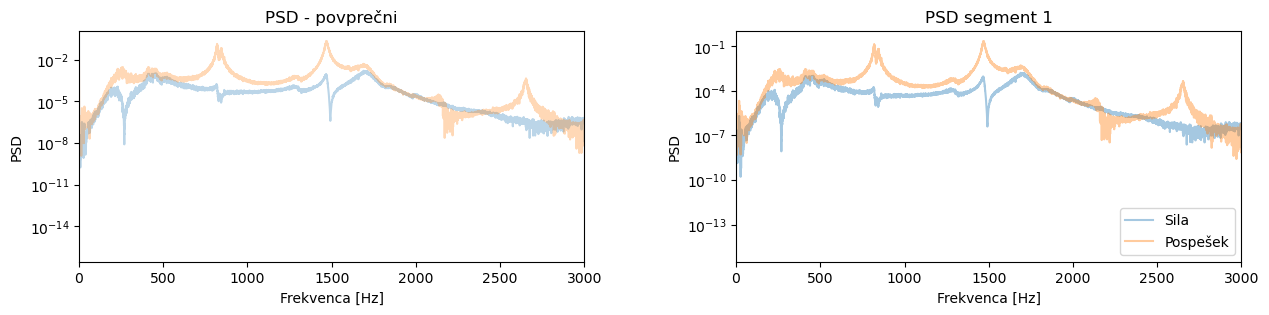

In [7]:
segment = 1;
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
fig.subplots_adjust(wspace=0.3)

ax1.set_title('PSD - povprečni')
ax1.semilogy(freq, PSD_F_avg, alpha=0.3, label='sila PSD')
ax1.semilogy(freq, PSD_A_avg, alpha=0.3, label='pospešek_PSD')
ax1.set_xlabel('Frekvenca [Hz]')
ax1.set_ylabel('PSD')
ax1.set_xlim(0, 3000)

ax2.set_title(f'PSD segment {segment}')
ax2.semilogy(freq, PSD_F[segment, :], alpha=0.4, label='Sila')
ax2.semilogy(freq, PSD_A[segment, :], alpha=0.4, label='Pospešek')
ax2.set_xlabel('Frekvenca [Hz]')
ax2.set_ylabel('PSD')
ax2.set_xlim(0, 3000)
ax2.legend(loc='lower right');

#### Prenosna funkcija $\alpha(\omega)$

Oceno FPF izračuno enostavno kot deljenje Odziva in Vzbujanja (v frekvenčni domeni). S tem ne upoštevamo šuma na vhodu in izhodu. 
$$\alpha(\omega) = \frac{A(\omega)}{F(\omega)}$$

(5, 25601)

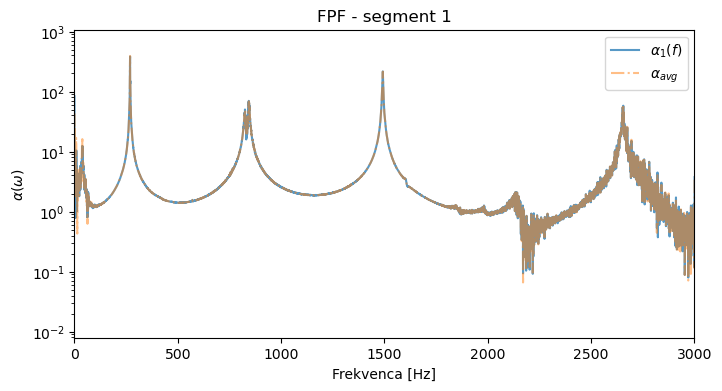

In [8]:
alpha = A/F                 # deljenje FFT pospeška s FFT sile za vsak segment
alpha_avg = A_avg/F_avg     # deljenje FFT povprečnega pospeška s FFT povprečne sile

# Izris
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(f'FPF - segment {segment}')
ax.semilogy(freq, np.abs(alpha[segment, :]), alpha=0.75, label=fr'$\alpha_{segment}(f)$')
ax.semilogy(freq, np.abs(alpha_avg), '-.', alpha=0.5, label=r'$\alpha_{avg}$')
ax.set_xlabel('Frekvenca [Hz]')
ax.set_ylabel(r'$\alpha(\omega)$')
ax.set_xlim(0, 3000)
ax.legend();
alpha.shape

Na zgornjem grafu vidimo (zaradi šuma v FPF), da smo frekvence v sredini izbranega območja vzbujali dobro medtem ko smo nižje vrekvence in tiste blizu 3kHz vzbujali nekoliko slabše. 

#### Cenilka $H_2$

Cenilka $H_2(\omega)$ prepostavlja nezanemarljivo količino naključnega šuma pri meritvi signala *vzbujanja* $f(t)$. Izračunamo jo:

$$
\begin{equation}
H_2(\omega) = \frac{S_{aa}(\omega)}{S_{af}(\omega)}.
\end{equation}
$$

Namesto celotnega avtospektra $S_{aa}$ lahko uproabimo tudi zgolj pozitivni del $G_{aa}$.

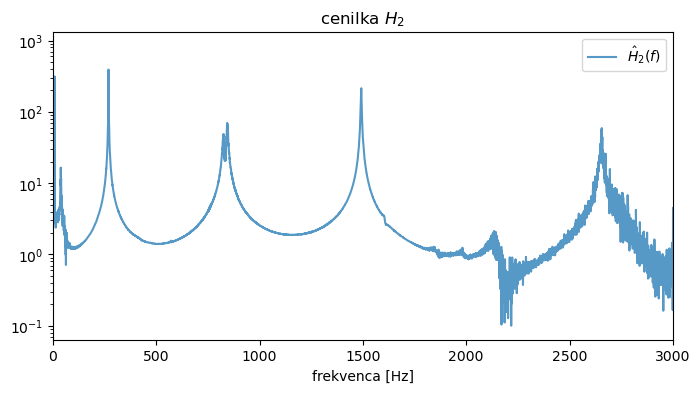

In [9]:
Gaa = A.conj()*A
Gaf = A.conj()*F

H_2 = np.mean(Gaa, axis=0) / np.mean(Gaf, axis=0)       # povprečenje spektrov za cenilko H2
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title(r'cenilka $H_2$')
ax.semilogy(freq, np.abs(H_2), alpha=0.75, label=r'$\hat{H}_2(f)$')
ax.set_xlabel('frekvenca [Hz]')
ax.set_xlim(0, 3000)
ax.legend();

#### Dodatek

Cenilki $H_1$ in $H_2$
\
Avto-spektri in križni-spektri izračunani s povprečenjem prekritih segmentov in oknjenjem
\
Dolžina posameznega segmenta = $\textbf{0.75}$ \
prekrivanje $50\%$ \
Okno : "Hann"

In [10]:
acc = x
force = f
acc.shape, force.shape

((5, 51200), (5, 51200))

In [11]:
a = np.hstack(acc)
f = np.hstack(force)

n_tock_v_segmentu = 0.75 * fs
int(n_tock_v_segmentu)

a.shape, f.shape

((256000,), (256000,))

In [12]:
window1 = 'hann';
freq_welch, G_aa = signal.csd(a, a, nperseg=int(n_tock_v_segmentu), fs=fs, window=f'{window1}')
freq_welch, G_af = signal.csd(a, f, nperseg=int(n_tock_v_segmentu), fs=fs, window=f'{window1}')

freq_welch, G_ff = signal.csd(f, f, nperseg=int(n_tock_v_segmentu), fs=fs, window=f'{window1}')
freq_welch, G_fa = signal.csd(f, a, nperseg=int(n_tock_v_segmentu), fs=fs, window=f'{window1}')

In [13]:
H1_welch = G_fa / G_ff
H2_welch = G_aa / G_af
H1_welch.shape, H2_welch.shape, freq_welch.shape
freq[:10], freq_welch[:10]

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 array([ 0.        ,  1.33333333,  2.66666667,  4.        ,  5.33333333,
         6.66666667,  8.        ,  9.33333333, 10.66666667, 12.        ]))

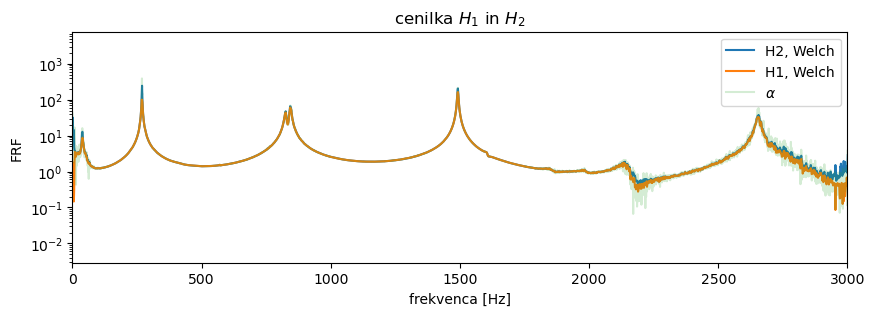

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 3))
ax1.set_title(r'cenilka $H_1$ in $H_2$')
ax1.semilogy(freq_welch, np.abs(H2_welch), label=f'H2, Welch')
ax1.semilogy(freq_welch, np.abs(H1_welch), label=f'H1, Welch')
ax1.semilogy(freq, np.abs(alpha_avg), alpha=0.2,  label=r'$\alpha$')
ax1.set_xlim(0,3000)
ax1.set_xlabel('frekvenca [Hz]')
ax1.set_ylabel('FRF')
ax1.legend();

#### Izračun koherence meritve 

$$
\gamma_{fx}^2(f) = \frac{H_1(\omega)}{H_2(\omega)}
$$

Koherenco lahko izračunamo kot razmerje cenilk $H_1$ in $H_2$

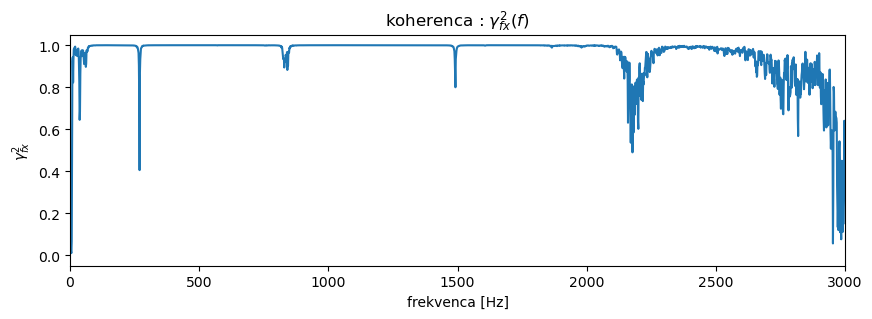

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title(r'koherenca : $\gamma_{fx}^2(f)$')
ax.plot(freq_welch, np.abs(H1_welch/H2_welch), label=f'H1/H2, Welch')
ax.set_xlabel('frekvenca [Hz]')
ax.set_ylabel(r'$\gamma_{fx}^2$')
ax.set_xlim(0, 3000);